# DataLoad

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [4]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

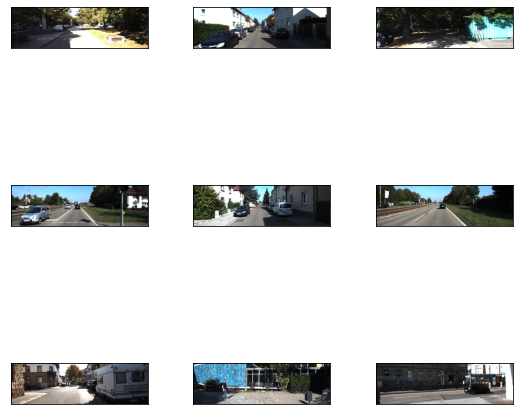

In [5]:
_ = tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### 데이터 확인

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.59, -1.49,  2.52,  2.24, -1.61], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.41186666, 0.44596618, 0.50765336, 0.4818599 ],
       [0.43792   , 0.4044042 , 0.50936   , 0.43278584],
       [0.40386668, 0.67444444, 0.49322668, 0.7416586 ],
       [0.39712   , 0.7694283 , 0.49381334, 0.8429469 ],
       [0.47074667, 0.45102254, 0.55776   , 0.47136876]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.26, 1.6 , 3.56],
       [1.37, 1.63, 3.57],
       [1.38, 1.35, 3.3 ],
       [1.59, 1.73, 4.02],
       [2.26, 1.64, 5.2 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-1.39,  1.73, 27.81],
       [-4.95,  2.  , 39.72],
       [11.95,  2.18, 32.11],
       [18.79,  2.44, 34.7 ],
       [-2.79,  1.81, 52.88]], dtype=float32)>, 'oc

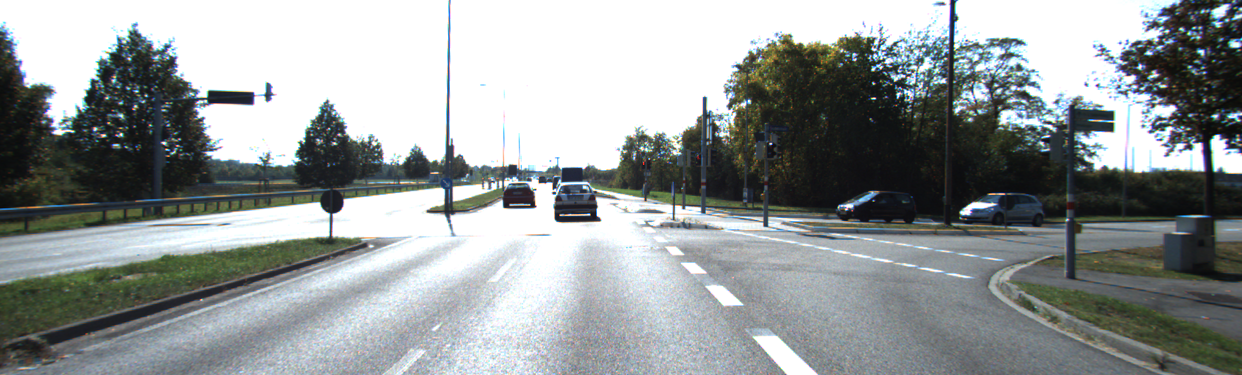

In [7]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

### 이미지 위에 바운딩 박스 그리기

width: 1242  height: 375
(5, 4)
[553.89    220.55    598.47    184.62999]
[502.27002 210.78    537.52    183.98999]
[837.66 223.55 921.14 190.04]
[ 955.62994  226.08    1046.9401   189.81999]
[560.17 198.47 585.44 165.84]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FA4F45A9450>


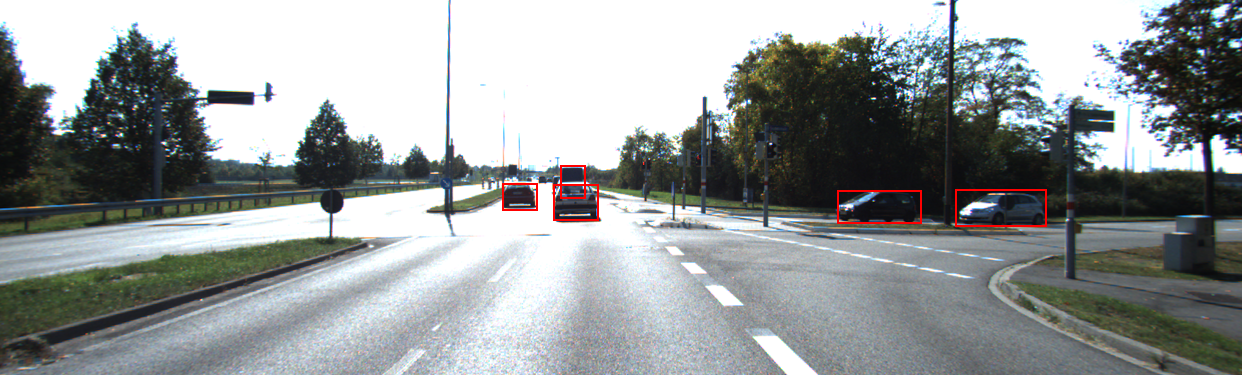

In [8]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

+ API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장   
+ 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성   
+ 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의

### 클래스 및 바운딩 박스 정보 추출

In [9]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [24:45<00:00,  4.27it/s]


In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:51<00:00,  4.14it/s]


### 클래스 맵핑

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


In [12]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-12-26 20:57:59.113156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-26 20:58:01.105417: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-26 20:58:01.106577: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-26 20:58:01.131522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 20:58:01.132352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-26 20:58:01.132392: I tensorflow/stream_executor/platform/default/dso_lo

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-12-26 21:34:58.129436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-26 21:34:59.935981: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-26 21:34:59.937097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-26 21:34:59.963181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 21:34:59.963951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-26 21:34:59.963996: I tensorflow/stream_executor/platform/default/dso_lo

## 시각화

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1 Physical GPUs, 1 Logical GPUs


[594.1827  174.61064 626.0043  206.85362]
[373.96188 181.74155 420.0916  208.49202]
[196.77734 132.93166 356.8197  230.61775]
[530.78986 159.54079 564.0156  190.57515]
[440.26663 173.08734 473.67316 196.91397]


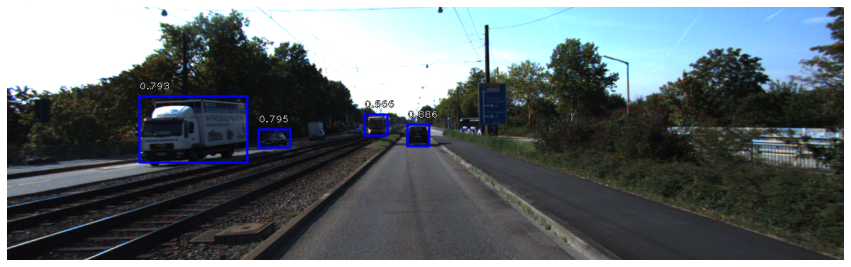

In [16]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

### 다른이미지도 확인

[775.1716  146.29399 840.5446  311.09995]
[752.2174  124.74782 870.07477 314.78244]


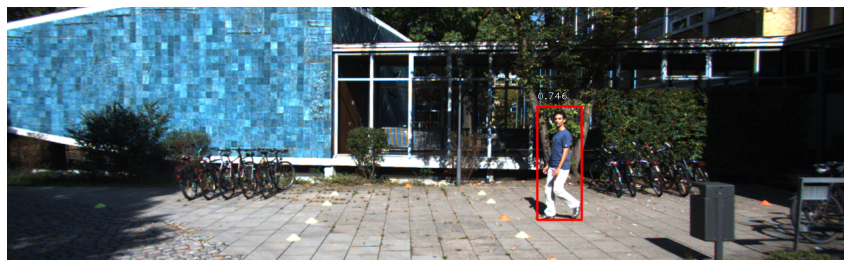

In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

--- 

+ 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
+ 사람이 한 명 이상 있는 경우
+ 차량의 크기(width or height)가 300px이상인 경우


[775.1716  146.29399 840.5446  311.09995]
[752.2174  124.74782 870.07477 314.78244]


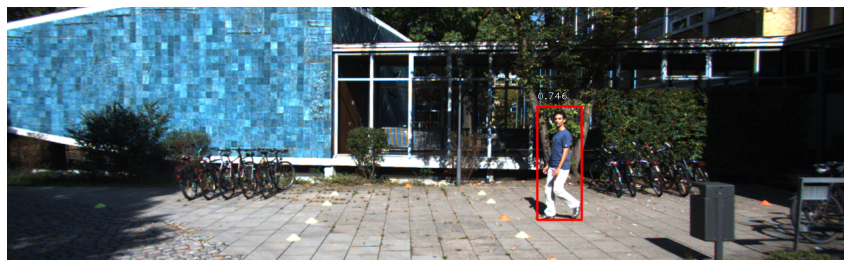

Stop


In [68]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=True):
    
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    # display images
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"
    if  visualize:
        answer = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5: 
                break
            b = box.astype(int) 
            
            weight = b[2] - b[0]
            height = b[3] - b[1]
            
            #label = 1이면 사람
            
            #사람이 한명이상있는경우 or 차량의 크기(weight or height)가 300px(size_limit 이상인 경우
            if weight >= size_limit or height >= size_limit or label == 1: 
                answer = 'Stop'
            else :
                answer = 'Go'
                
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return answer

print(self_drive_assist(img_path))

[417.45392 161.93399 500.17947 332.91995]
[435.13104 170.90591 486.49738 305.57135]


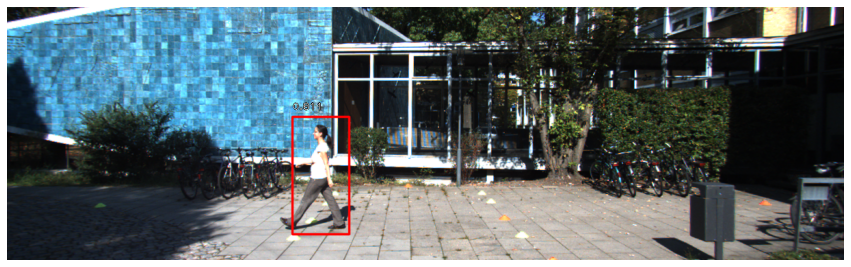

Stop


In [69]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_2.png'
print(self_drive_assist(img_path))

In [70]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f'pred : {pred}, answer : {answer}')
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

[775.1716  146.29399 840.5446  311.09995]
[752.2174  124.74782 870.07477 314.78244]


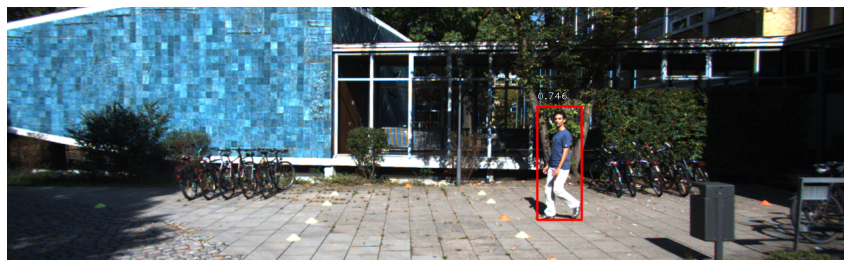

pred : Stop, answer : Stop
[417.45392 161.93399 500.17947 332.91995]
[435.13104 170.90591 486.49738 305.57135]


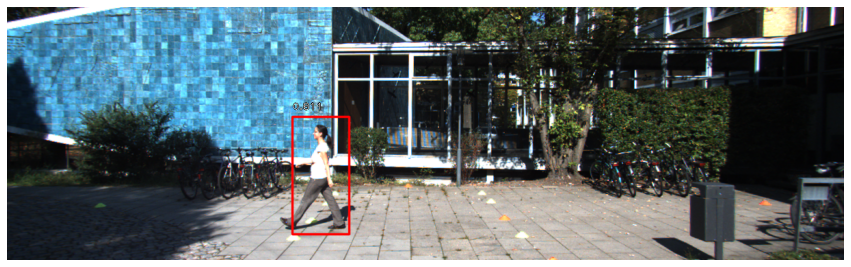

pred : Stop, answer : Stop
[  0.      201.4005  301.7647  367.16794]
[751.8125  157.33167 883.0704  209.31073]
[ 992.05206  158.2743  1029.9221   214.46819]
[1006.91656  161.06525 1035.8956   217.12953]


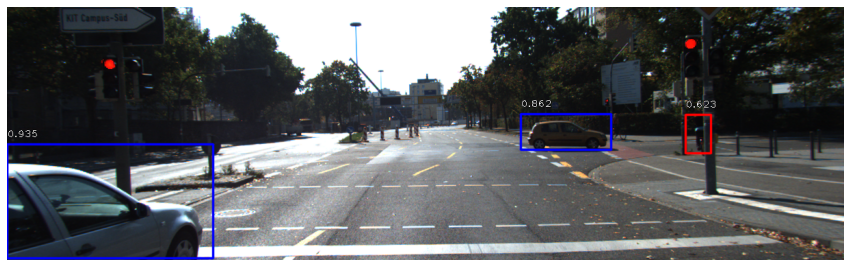

pred : Stop, answer : Stop
[655.76117 144.12915 741.0046  228.737  ]
[425.05475 155.90694 554.0134  209.27576]
[ 757.1145    66.77921 1142.3181   363.61005]
[ 61.81457 158.58768 382.49133 301.7221 ]
[358.25555 169.40918 491.51996 218.26561]
[  4.805736 128.34113  346.07175  355.60544 ]


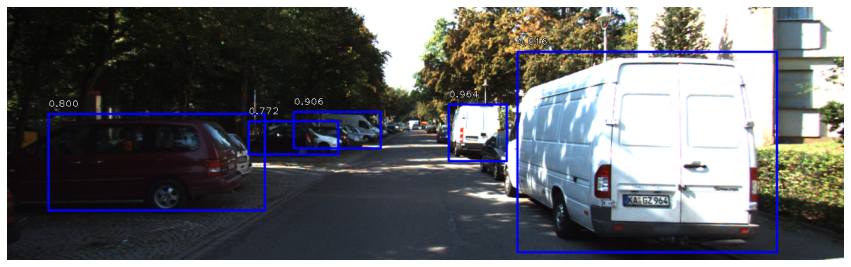

pred : Go, answer : Stop
[ 897.6295   171.33261 1241.0684   373.6249 ]
[564.2963  175.87155 616.768   217.06992]
[735.4346  165.70049 858.0165  250.22217]
[700.2147  147.74269 780.09485 219.87546]
[713.78467 152.36296 825.92426 234.62747]
[694.5607  152.93074 753.5334  206.85968]
[586.06946 176.39091 628.9397  206.76555]


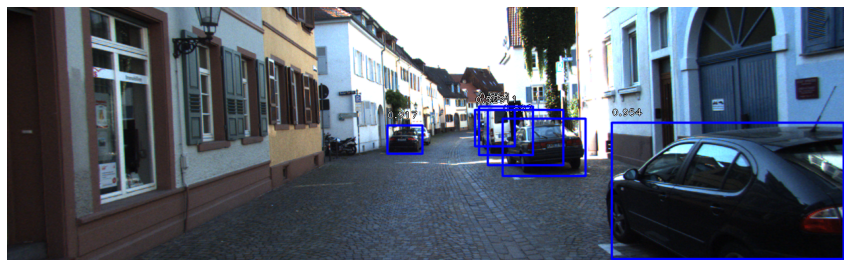

pred : Go, answer : Stop
[594.1827  174.61064 626.0043  206.85362]
[373.96188 181.74155 420.0916  208.49202]
[196.77734 132.93166 356.8197  230.61775]
[530.78986 159.54079 564.0156  190.57515]
[440.26663 173.08734 473.67316 196.91397]


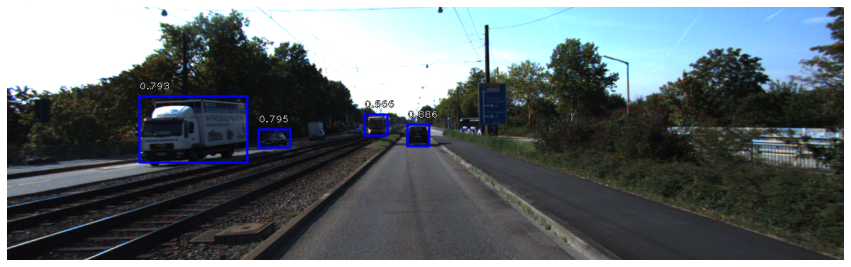

pred : Go, answer : Go
[516.1789  175.29108 569.7655  216.02979]
[627.1778  175.04741 666.6311  213.06505]
[533.81604 175.2022  578.9181  207.95215]


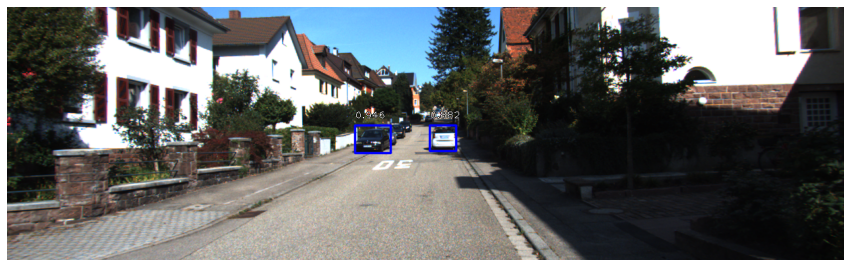

pred : Go, answer : Go
[817.1885  147.39594 890.602   176.83008]
[539.9309  167.37154 567.1874  190.41422]


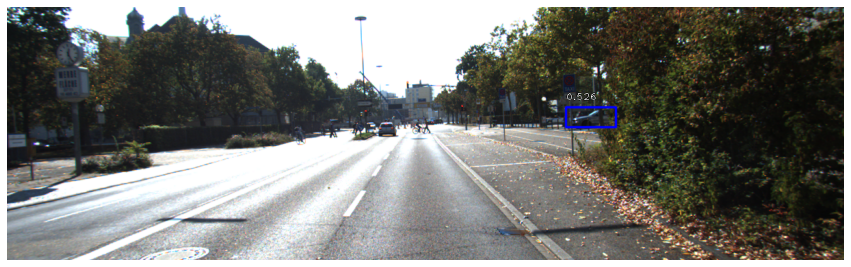

pred : Go, answer : Go
[692.4208  174.3907  793.3337  253.25655]
[698.0132  178.3826  760.3592  232.67284]


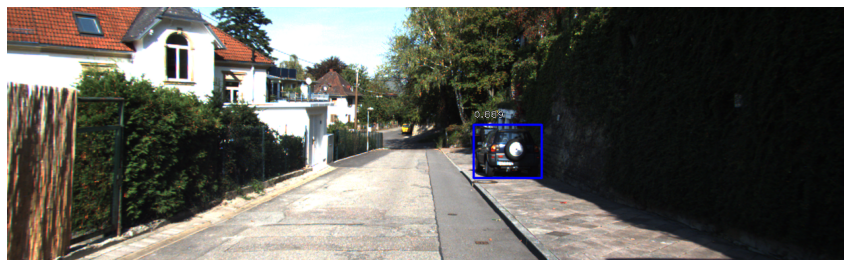

pred : Go, answer : Go
[ 12.830777 189.61713  217.24854  303.47397 ]
[161.54204 187.39317 333.22247 254.84955]
[291.77618 176.04918 401.9192  226.57042]
[209.34732 179.16927 365.64462 242.4069 ]
[439.17142 175.41086 493.5816  208.89058]
[ 92.85257 191.39124 303.85846 269.3616 ]
[333.59732 176.35178 430.3923  224.219  ]


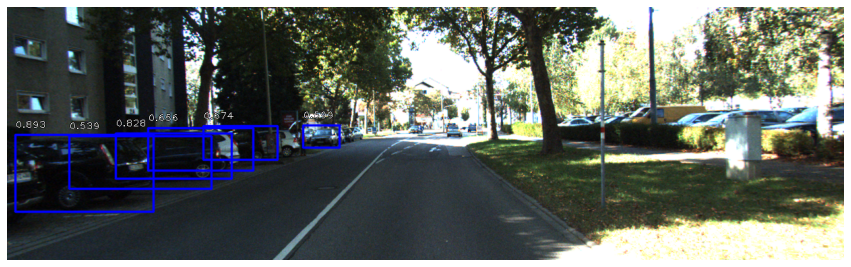

pred : Go, answer : Go
80점입니다.


In [71]:
test_system(self_drive_assist)

---
기본적으로 'Go'를 리턴하게 설정을 하고 정지조건에 만족을 할시에 'Stop'을 리턴하게 하였다.
80점이 나왔는데 score값을 줄이면서 정답의 폭을 넓히려고 했지만 80점에서 더이상 오르지 못하였다.